## GAN(Generative Adversarial Networks)

In [7]:
import os, warnings
# 경고 메시지 무시하거나 숨길때(ignore), 다시보이게(default)
# warnings.filterwarnings(action='default')
warnings.filterwarnings(action='ignore')
from IPython.display import display, Image

## 01 데이터 가져오기

In [8]:
# https://arxiv.org/abs/1406.2661
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True)

Extracting ./mnist/data/train-images-idx3-ubyte.gz
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


## 02 기본 변수 설정

In [9]:
total_epoch = 100       # epoch 수 설정
batch_size = 100        # 배치 사이즈
learning_rate = 0.0002  # 학습률

# 신경망 레이어 구성 옵션
n_hidden = 256            # 은닉층 노드
n_input = 28 * 28         # 입력 
n_noise = 128             # 생성기의 입력값으로 사용할 노이즈의 크기

## 03 신경망 모델 구성

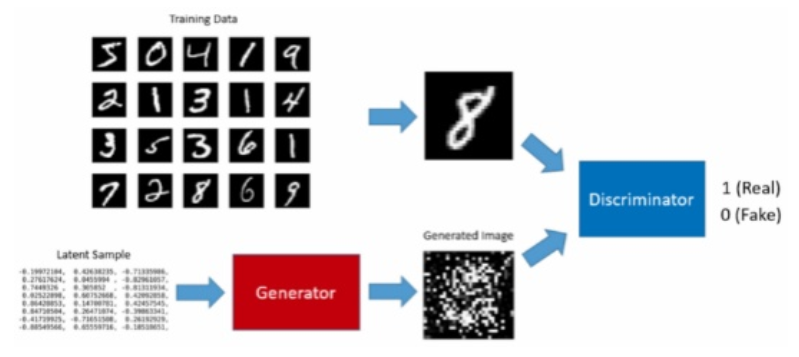

In [11]:
display(Image(filename="../img/gan01.png"))

* https://go-hard.tistory.com/1 참조

### 노이즈 입력(Z), 실제 입력(X)

In [13]:
# GAN 도 Unsupervised 학습이므로 Autoencoder 처럼 Y 를 사용하지 않습니다.
X = tf.placeholder(tf.float32, [None, n_input])

# 노이즈 Z를 입력값으로 사용합니다.
Z = tf.placeholder(tf.float32, [None, n_noise])

### 생성자 신경망 변수 선언

* n_noise : 128, n_hidden : 256
* G_W1, G_b1 : 첫번째 입력에서 은닉층으로 보내는 가중치와 편향변수
* G_W2, G_b2 : 출력층에서 사용할 편향변수

In [15]:
# 신경망 레이어 구성 옵션
# n_noise = 128         # 생성기의 입력값으로 사용할 노이즈의 크기
# n_hidden = 256        # 은닉층 노드

# n_input = 28 * 28     # 입력 

In [14]:
G_W1 = tf.Variable(tf.random_normal([n_noise, n_hidden], stddev=0.01))
G_b1 = tf.Variable(tf.zeros([n_hidden]))
G_W2 = tf.Variable(tf.random_normal([n_hidden, n_input], stddev=0.01))
G_b2 = tf.Variable(tf.zeros([n_input]))

Instructions for updating:
Colocations handled automatically by placer.


### 판별자 신경망 변수 선언

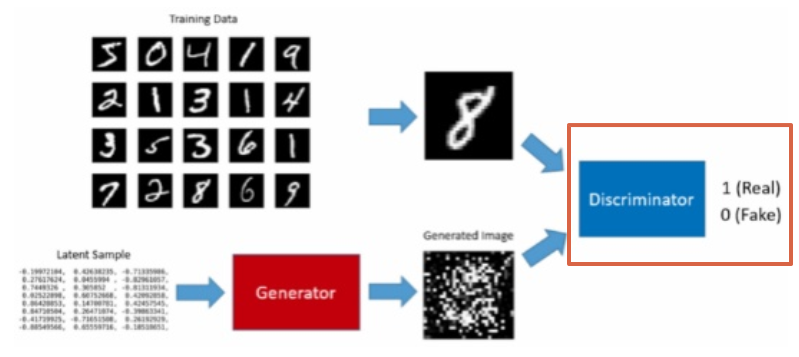

In [17]:
display(Image(filename="../img/gan02.png"))

In [19]:
# 판별기 신경망에 사용하는 변수들입니다.
D_W1 = tf.Variable(tf.random_normal([n_input, n_hidden], stddev=0.01))
D_b1 = tf.Variable(tf.zeros([n_hidden]))

# 판별기의 최종 결과값은 얼마나 진짜와 가깝냐를 판단하는 
# 한 개의 스칼라값입니다.
D_W2 = tf.Variable(tf.random_normal([n_hidden, 1], stddev=0.01))
D_b2 = tf.Variable(tf.zeros([1]))

## 04 신경망 구성( 생성자(G), 구분자(D) )

### 생성자(G) 신경망 구성

 * 무작위 생성한 노이즈를 받아, 가중치와 편향을 반영하여 은닉층 구성.
 * sigmoid 함수를 이용하여 최종 결과값 0~1 사이의 값 반환

In [20]:
def generator(noise_z):
    hidden = tf.nn.relu(
                    tf.matmul(noise_z, G_W1) + G_b1)
    output = tf.nn.sigmoid(
                    tf.matmul(hidden, G_W2) + G_b2)

    return output

### 구분자(D) 신경망 구성

 * 구분자 신경망 구성, 가중치와 편향을 반영한 데이터 출력
 * sigmoid 함수를 이용하여 최종 결과값 0~1 사이의 값 반환

In [22]:
def discriminator(inputs):
    hidden = tf.nn.relu(
                    tf.matmul(inputs, D_W1) + D_b1)
    output = tf.nn.sigmoid(
                    tf.matmul(hidden, D_W2) + D_b2)

    return output

### 노이즈 생성 함수

In [23]:
# 랜덤한 노이즈(Z)를 만듭니다.
def get_noise(batch_size, n_noise):
    return np.random.normal(size=(batch_size, n_noise))

### 노이즈를 이용한 랜덤한 이미지 생성 및 판별망 신경망 이용 판별값 구하기

In [24]:
# 노이즈를 이용해 랜덤한 이미지를 생성합니다.
# Z에는 실행 시, noise가 입력됨.
G = generator(Z)
# 노이즈를 이용해 생성한 이미지가 진짜 이미지인지 판별한 값을 구합니다.
D_fake = discriminator(G)  # 가짜 이미지 넣기 
# 진짜 이미지를 이용해 판별한 값을 구합니다.
D_real = discriminator(X)  # 진짜 이미지 넣기

In [26]:
print(G)
print(D_fake)
print(D_real)

Tensor("Sigmoid:0", shape=(?, 784), dtype=float32)
Tensor("Sigmoid_1:0", shape=(?, 1), dtype=float32)
Tensor("Sigmoid_2:0", shape=(?, 1), dtype=float32)


 * GAN은 생성자(Generator) : 구분자가 1로 예측하도록 하는 것을 목표로 학습시킴. 
 * GAN은 구분자(Discriminator) : 진짜 데이터를 받으면 1로 가짜 데이터를 받으면 0으로 예측하도록 학습시킴.

## 05 GAN 모델의 최적화 

* loss_G와 loss_D를 최대화 하는 것. 단, 서로의 손실이 연관되어 있어, 두 손실값이 같이 증가가 어려움.
* loss_D를 최대화하기 위해서는 D_gene값을 최소화시킴.
* 판별기에 진짜 이미지를 넣었을 때에도 최대값을 : tf.log(D_real)
* 가짜 이미지를 넣었을 때에도 최대값을 : tf.log(1 - D_gene)

In [27]:
loss_D = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_fake))

* loss_G(생성자 손실)를 최대화하기 위해서는 D_gene값을 최대화 한다.
* 가짜 이미지를 넣었을 때, 판별기가 최대한 실제 이미지라고 판단하도록 생성기 신경망을 학습

In [28]:
# 결국 D_gene 값을 최대화하는 것이므로 다음과 같이 사용할 수 있습니다.
loss_G = tf.reduce_mean(tf.log(D_fake))

### loss_D 를 구할 때는 판별기 신경망에 사용되는 변수만 사용
### loss_G 를 구할 때는 생성기 신경망에 사용되는 변수만 사용

In [30]:
# loss_D 를 구할 때는 판별기 신경망에 사용되는 변수만 사용하고,
# loss_G 를 구할 때는 생성기 신경망에 사용되는 변수만 사용하여 최적화를 합니다.
D_var_list = [D_W1, D_b1, D_W2, D_b2]
G_var_list = [G_W1, G_b1, G_W2, G_b2]

In [31]:
# GAN 논문의 수식에 따르면 loss 를 극대화 해야하지만, minimize 하는 최적화 함수를 사용하기 때문에
# 최적화 하려는 loss_D 와 loss_G 에 음수 부호를 붙여줍니다.
train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D,
                                                         var_list=D_var_list)
train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G,
                                                         var_list=G_var_list)

### 06 모델학습

In [32]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

In [33]:
%%time

for epoch in range(total_epoch):
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)

        # 판별기와 생성기 신경망을 각각 학습시킵니다.
        _, loss_val_D = sess.run([train_D, loss_D],
                                 feed_dict={X: batch_xs, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G],
                                 feed_dict={Z: noise})

    print('Epoch:', '%04d' % epoch,
          'D loss: {:.4}'.format(loss_val_D),
          'G loss: {:.4}'.format(loss_val_G))
                                 
    #########
    # 학습이 되어가는 모습을 보기 위해 주기적으로 이미지를 생성하여 저장
    ######
    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G, feed_dict={Z: noise})

        fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))

        for i in range(sample_size):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape(samples[i], (28, 28)))

        plt.savefig('samples/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.close(fig)

print('최적화 완료!')

Epoch: 0000 D loss: -0.4394 G loss: -1.997
Epoch: 0001 D loss: -0.4831 G loss: -2.333
Epoch: 0002 D loss: -0.1296 G loss: -3.186
Epoch: 0003 D loss: -0.6119 G loss: -1.394
Epoch: 0004 D loss: -0.3188 G loss: -2.003
Epoch: 0005 D loss: -0.2194 G loss: -2.416
Epoch: 0006 D loss: -0.1212 G loss: -3.344
Epoch: 0007 D loss: -0.1976 G loss: -2.758
Epoch: 0008 D loss: -0.4429 G loss: -2.5
Epoch: 0009 D loss: -0.3757 G loss: -2.493
Epoch: 0010 D loss: -0.4561 G loss: -2.554
Epoch: 0011 D loss: -0.4461 G loss: -2.234
Epoch: 0012 D loss: -0.3111 G loss: -2.569
Epoch: 0013 D loss: -0.323 G loss: -2.285
Epoch: 0014 D loss: -0.367 G loss: -2.661
Epoch: 0015 D loss: -0.4759 G loss: -2.396
Epoch: 0016 D loss: -0.3834 G loss: -2.566
Epoch: 0017 D loss: -0.2517 G loss: -2.641
Epoch: 0018 D loss: -0.2633 G loss: -2.608
Epoch: 0019 D loss: -0.3133 G loss: -2.693
Epoch: 0020 D loss: -0.3645 G loss: -2.71
Epoch: 0021 D loss: -0.3366 G loss: -2.698
Epoch: 0022 D loss: -0.4076 G loss: -2.211
Epoch: 0023 D lo